# Install Dependencies And Import Libraries


## Installing Dependencies

In [ ]:
!pip install torch-geometric
# !pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

## Imported Libraries

In [ ]:
from google.colab import files
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import SAGEConv
from datetime import datetime
import copy
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import random
from captum.attr import IntegratedGradients

# Uploading Json


In [ ]:
uploaded = files.upload()

Saving new_target_file_plus_266.json to new_target_file_plus_266.json


In [ ]:
# Load the JSON data
with open('new_target_file_plus_266.json', 'r') as f:
    creators_data = json.load(f)

# Inspect the first few items to get a sense of the data
list(creators_data.items())[:3]  # Show first 3 YouTubers

print(len(creators_data))

1798


# Creating and Training the Model

## Data Preprocessing

In [ ]:
def find_average_time_between_videos(videos):
    """
    This function aims to get the average time between videos given an array of the creator's videos
    """
    if len(videos) < 2:
        return 0  # Not enough videos to compare

    # Sort videos by publish time
    videos.sort(key=lambda v: datetime.strptime(v['publishedAt'], "%Y-%m-%dT%H:%M:%SZ"))

    # Convert publish times to datetime objects
    publish_dates = [
        datetime.strptime(video['publishedAt'], "%Y-%m-%dT%H:%M:%SZ")
        for video in videos
    ]

    # Calculate differences in days
    total_days = 0
    for i in range(1, len(publish_dates)):
        diff = (publish_dates[i] - publish_dates[i-1]).days
        total_days += diff

    avg_days = total_days / (len(publish_dates) - 1)
    return avg_days

In [ ]:
def find_average_like_growth(videos):
    """
    This function aims to get the average like growth between videos given an array of the creator's videos
    """
    if len(videos) < 2:
        return 0  # Not enough videos to compare

    # Sort videos by publish time
    videos.sort(key=lambda v: datetime.strptime(v['publishedAt'], "%Y-%m-%dT%H:%M:%SZ"))

    # Convert publish times to datetime objects
    like_counts = [video.get('likeCount', 0) for video in videos]

    # Calculate differences in days
    total_like_growth = 0
    for i in range(1, len(like_counts)):
        diff = (like_counts[i] - like_counts[i-1])
        total_like_growth += diff

    avg_growth = total_like_growth / (len(like_counts) - 1)
    return avg_growth


In [ ]:
# Preprocess the creator features and video features
creators = []
videos = []

import torch
import numpy as np

creators = []
videos = []

for creator_id, creator_info in creators_data.items():
    followers = creator_info.get('noOfSubscribers', 0)

    video_views = [video.get('viewCount', 0) for video in creator_info['videos']]
    video_likes = [video.get('likeCount', 0) for video in creator_info['videos']]
    video_comments = [video.get('commentCount', 0) for video in creator_info['videos']]

    num_videos = len(creator_info['videos']) or 1  # avoid divide-by-zero

    video_like_per_comment = [video.get('likesToComments', 0) for video in creator_info['videos']]

    video_follower_per_like = []
    for i in range(num_videos):
        video_follower_per_like.append(followers / (video_likes[i]+1))



    # Creator features
    avg_views = np.mean(video_views)
    avg_likes = np.mean(video_likes)
    avg_comments = np.mean(video_comments)
    avg_like_ratio = np.mean([likes / (views + 1) for likes, views in zip(video_likes, video_views)])
    avg_days_between_uploads = find_average_time_between_videos(creator_info['videos'])  # <== New feature
    avg_like_growth = find_average_like_growth(creator_info['videos'])  # <== New feature
    avg_video_like_per_comment = np.mean(video_like_per_comment)
    avg_video_follower_per_like = np.mean(video_follower_per_like)


    creator_features = [
        followers,
        avg_views,
        avg_likes,
        avg_video_follower_per_like,
        avg_comments,
        avg_video_like_per_comment,
        avg_like_ratio,
        avg_like_growth,
        num_videos,
        avg_days_between_uploads
    ]

    creators.append((creator_id, torch.tensor(creator_features, dtype=torch.float)))

    # Video features
    for video in creator_info['videos']:
        views = video.get('viewCount', 0)
        likes = video.get('likeCount', 0)
        comments = video.get('commentCount', 0)
        like_ratio = video.get('likesToViews', 0)
        comment_ratio = video.get('commentsToViews', 0)

        video_features = [
            views,
            likes,
            comments,
            like_ratio,
            comment_ratio
        ]

        videos.append((creator_id, video['videoId'], torch.tensor(video_features, dtype=torch.float)))

In [ ]:
test = []

for creator_id, creator_info in creators_data.items():
    vidoes = creator_info['videos']
    test.append(find_average_time_between_videos(vidoes))
print(test[:5])

[12.241379310344827, 7.620689655172414, 23.586206896551722, 0.06896551724137931, 0.7586206896551724]


In [ ]:
#Prepare creator features (pad if needed)
padded_creator_features = []
creator_ids = []
for creator_id, features in creators:
    padded = torch.cat([features, torch.zeros(10 - len(features))], dim=0)
    padded_creator_features.append(padded)
    creator_ids.append(creator_id)

#Prepare video features (pad and handle NaNs)
padded_video_features = []
video_ids = []
for creator_id, video_id, video_features in videos:
    video_features = torch.nan_to_num(video_features, nan=0.0)
    padded = torch.cat([video_features, torch.zeros(10 - len(video_features))], dim=0)
    padded_video_features.append(padded)
    video_ids.append((creator_id, video_id))

#Combine all node features
all_features = padded_creator_features + padded_video_features
features = torch.stack(all_features)

#Build node index mapping
node_mapping = {}
for idx, creator_id in enumerate(creator_ids):
    node_mapping[creator_id] = idx
offset = len(creator_ids)
for idx, vid_key in enumerate(video_ids):
    node_mapping[vid_key] = offset + idx

#Build edges (creator ↔ video)
edges = []
for creator_id, creator_info in creators_data.items():
    creator_idx = node_mapping.get(creator_id)
    for video in creator_info.get('videos', []):
        video_key = (creator_id, video['videoId'])
        video_idx = node_mapping.get(video_key)
        if video_idx is not None and creator_idx is not None:
            edges.append([creator_idx, video_idx])
            edges.append([video_idx, creator_idx])
        else:
            print(f"Missing node in mapping: {video_key}")

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

#Labels
labels = torch.tensor(
    [creator_info.get('influencer', 0) for creator_id, creator_info in creators_data.items()],
    dtype=torch.long
)

#Create Graph Data
data = Data(x=features, edge_index=edge_index, y=labels)

## Splitting Data into Train and Test Sets

In [ ]:
# Set the seed for all libraries and devices (this part is already done correctly)
SEED = 248
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Number of creators
n_creators = len(creator_ids)

# Use np.random.shuffle to shuffle deterministically
indices = np.arange(n_creators)
np.random.shuffle(indices)  # This is now seeded by np.random.seed

# Splits
train_split = int(0.7 * n_creators)
val_split = int(0.85 * n_creators)

train_idx = indices[:train_split]
val_idx = indices[train_split:val_split]
test_idx = indices[val_split:]

# Initialize masks
num_nodes = len(features)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign masks based on indices
for i in train_idx:
    train_mask[i] = True
for i in val_idx:
    val_mask[i] = True
for i in test_idx:
    test_mask[i] = True

# Create data object
data = Data(x=features, edge_index=edge_index, y=labels)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Get creator-only masks
creator_train_mask = data.train_mask[:n_creators]
creator_val_mask = data.val_mask[:n_creators]
creator_test_mask = data.test_mask[:n_creators]

# Get creator-only features
creator_x = data.x[:n_creators]
creator_y = data.y  # Already only creator labels

# Now index correctly
x_train = creator_x[creator_train_mask]
y_train = creator_y[creator_train_mask]

x_val = creator_x[creator_val_mask]
y_val = creator_y[creator_val_mask]

x_test = creator_x[creator_test_mask]
y_test = creator_y[creator_test_mask]


In [ ]:
# Debug print statements
print("Total nodes:", len(data.x))  # Should be creators + videos
print("Total creator nodes:", n_creators)
print("Train mask count:", data.train_mask[:n_creators].sum().item())
print("Val mask count:", data.val_mask[:n_creators].sum().item())
print("Test mask count:", data.test_mask[:n_creators].sum().item())

Total nodes: 38367
Total creator nodes: 1798
Train mask count: 1258
Val mask count: 270
Test mask count: 270


## Creating and Testing the Model

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train():
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)
    out_creators = out[:len(data.y)]
    train_mask_creators = data.train_mask[:len(data.y)]
    loss = loss_fn(out_creators[train_mask_creators].squeeze(), data.y[train_mask_creators].float())

    loss.backward()
    optimizer.step()

    # Convert logits to predictions (using threshold of 0.5 for binary classification)
    train_pred = torch.sigmoid(out_creators[train_mask_creators]).squeeze()
    train_pred = (train_pred > 0.5).long()

    train_acc = accuracy_score(
        data.y[train_mask_creators].cpu(),
        train_pred.cpu()
    )
    train_f1 = f1_score(
        data.y[train_mask_creators].cpu(),
        train_pred.cpu(),
        average = 'macro'
    )

    return loss.item(), train_acc, train_f1

def evaluate(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    out_creators = out[:len(data.y)]
    pred = torch.sigmoid(out_creators[mask[:len(data.y)]]).squeeze()
    pred = (pred > 0.75).long()

    correct = pred.eq(data.y[mask[:len(data.y)]]).sum().item()
    acc = correct / mask[:len(data.y)].sum().item()
    f1 = f1_score(data.y[mask[:len(data.y)]].cpu(), pred.cpu(), average = 'macro')
    return acc, f1


# Initialize model, optimizer, loss
in_channels = data.num_node_features
hidden_channels = 128
out_channels = 1  # Binary classification: 1 output for influencer vs not

model = GraphSAGE(in_channels, hidden_channels, out_channels, dropout=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = torch.nn.BCEWithLogitsLoss()

# Reset everything before retraining
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(1, 201):
    loss, train_acc, train_f1 = train()
    val_acc, val_f1 = evaluate(data.val_mask)

    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")


# Final test accuracy
test_acc, test_f1 = evaluate(data.test_mask)
print(f"\nTest Accuracy: {test_acc:.4f}\nTest F1: {test_f1:.4f}")

Epoch 050 | Loss: 62149.7930 | Train Acc: 0.6097 | Train F1: 0.5832 | Val Acc: 0.5704 | Val F1: 0.5111
Epoch 100 | Loss: 34417.5273 | Train Acc: 0.6184 | Train F1: 0.6028 | Val Acc: 0.7185 | Val F1: 0.7108
Epoch 150 | Loss: 13966.5039 | Train Acc: 0.6097 | Train F1: 0.5867 | Val Acc: 0.6556 | Val F1: 0.6315
Epoch 200 | Loss: 10554.6660 | Train Acc: 0.6359 | Train F1: 0.6015 | Val Acc: 0.7296 | Val F1: 0.7232

Test Accuracy: 0.7296
Test F1: 0.7196


## Identifying Important Features

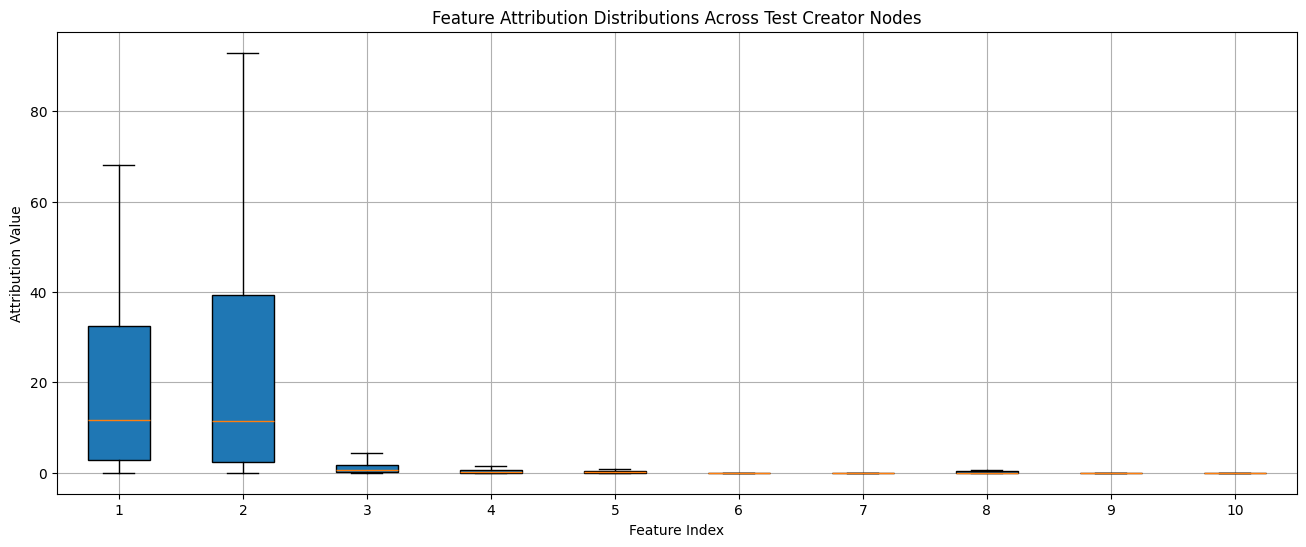

In [ ]:
class NodeFocusedModel(nn.Module):
    def __init__(self, model, edge_index, node_index):
        super().__init__()
        self.model = model
        self.edge_index = edge_index
        self.node_index = node_index

    def forward(self, x):
        out = self.model(x, self.edge_index)
        return out[self.node_index].unsqueeze(0)  # Only the output for this node

# Get test creator node indices
n_creators = len(data.y)
test_indices = data.test_mask[:n_creators].nonzero(as_tuple=True)[0]

# Store attributions
all_attributions = []
all_targets = []

# Use full input
input_x = data.x.requires_grad_(True)
baseline = torch.zeros_like(input_x)

# Loop through test creator nodes
for sample_index in test_indices:
    sample_index = sample_index.item()

    # Wrap the model for this node
    focused_model = NodeFocusedModel(model, data.edge_index, sample_index)
    focused_model.eval()

    ig = IntegratedGradients(focused_model)

    target_class = 0 #data.y[sample_index].item()

    attributions, _ = ig.attribute(inputs=input_x,
                                   baselines=baseline,
                                   target=target_class,
                                   return_convergence_delta=True)

    # Get only this node’s attribution
    node_attr = attributions[sample_index].detach().numpy()
    all_attributions.append(node_attr)
    all_targets.append(target_class)

# Convert to NumPy array
all_attributions = np.abs(np.stack(all_attributions))  # shape: [num_nodes, num_features]
subset_attributions = all_attributions#[:, :5]  # shape: [num_nodes, 5]

# Summary plot across test nodes
plt.figure(figsize=(16, 6))
plt.boxplot(subset_attributions, vert=True, patch_artist=True, showfliers=False)
plt.title('Feature Attribution Distributions Across Test Creator Nodes')
plt.xlabel('Feature Index')
plt.ylabel('Attribution Value')
plt.grid(True)
plt.show()